### STOCK ANALYSIS

This Stock analysis is examination of a specific index from the Stock market. this is more of a technical analysis than a fundamental one. it's being based on the history of a stock price, and predict future movement. 

we will be doing the following:
1. Import Librarier and Dependencies
2. Import Stock Data
3. Clean Data
4. plot existing data (analysis)
5. build ML to train and test Data (Linear Regression)
6. present our predicted Findings

### DEPENDENCIES

In [1]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

### IMPORT CSV

In [2]:
#load assesment file

tsla = "resources/HistoricalData_TSLA.csv"
tsla_df = pd.read_csv(tsla)
tsla_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/24/2021,$606.44,34558090,$581.6,$614.48,$573.65
1,05/21/2021,$580.88,26030600,$596.11,$596.68,$580
2,05/20/2021,$586.78,30821120,$575,$588.85,$571.07
3,05/19/2021,$563.46,39578400,$552.55,$566.21,$546.98
4,05/18/2021,$577.87,36830570,$568,$596.25,$563.38


### CLEAN, RESHAPE AND CONVERT DATATYPE

In [3]:
tsla_df['Date']= pd.to_datetime(tsla_df['Date'])
tsla_df['Close/Last'] = tsla_df['Close/Last'].str.replace('$','')
tsla_df['Open'] = tsla_df['Open'].str.replace('$','')
tsla_df['High'] = tsla_df['High'].str.replace('$','')
tsla_df['Low'] = tsla_df['Low'].str.replace('$','')
tsla_df = tsla_df.apply( pd.to_numeric)

### FORMAT DATE COLUMN

In [4]:
tsla_df['Date']= pd.to_datetime(tsla_df['Date'])
tsla_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2021-05-24,606.44,34558090,581.60,614.48,573.65
1,2021-05-21,580.88,26030600,596.11,596.68,580.00
2,2021-05-20,586.78,30821120,575.00,588.85,571.07
3,2021-05-19,563.46,39578400,552.55,566.21,546.98
4,2021-05-18,577.87,36830570,568.00,596.25,563.38


### DATA MANIPULATION
By understanding the Data and creating new data to be consumed by our models such as below

#### CREATE ADDITIONAL DATA

In [5]:
tsla_df['Open_Close'] = (tsla_df['Open'] - tsla_df['Close/Last'])/tsla_df['Open']
tsla_df['High_Low'] = (tsla_df['High'] - tsla_df['Low'])/tsla_df['Low']
tsla_df['Increase_Decrease'] = np.where(tsla_df['Volume'].shift(-1) > tsla_df['Volume'],1,0)
tsla_df['Buy_Sell_on_Open'] = np.where(tsla_df['Open'].shift(-1) > tsla_df['Open'],1,0)
tsla_df['Buy_Sell'] = np.where(tsla_df['Close/Last'].shift(-1) > tsla_df['Close/Last'],1,0)
tsla_df['Returns'] = tsla_df['Close/Last'].pct_change()
tsla_df = tsla_df.dropna()
tsla_df.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,580.88,26030600,596.110,596.68,580.00,0.025549,0.028759,1,0,1,-0.042148
2,2021-05-20,586.78,30821120,575.000,588.85,571.07,-0.020487,0.031135,1,0,0,0.010157
3,2021-05-19,563.46,39578400,552.550,566.21,546.98,-0.019745,0.035157,0,1,1,-0.039742
4,2021-05-18,577.87,36830570,568.000,596.25,563.38,-0.017377,0.058344,0,1,0,0.025574
5,2021-05-17,576.83,32247800,575.553,589.73,561.20,-0.002219,0.050837,1,1,1,-0.001800


### SPLIT DATAFRAME

In [6]:
#setup datetime for first 4 years
start_date = "2016-05-24"
end_date = "2020-05-24"

after_start_date = tsla_df["Date"] >= start_date
before_end_date = tsla_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
tsla_df_4 = tsla_df.loc[between_two_dates]
tsla_df_4.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
252,2020-05-22,163.376,49937375,164.4348,166.356,162.400,0.006439,0.024360,1,0,1,-0.002430
253,2020-05-21,165.520,61272900,163.2000,166.500,159.200,-0.014216,0.045854,0,1,0,0.013123
254,2020-05-20,163.112,36546355,164.1000,165.200,162.360,0.006021,0.017492,1,0,0,-0.014548
255,2020-05-19,161.602,48182610,163.0340,164.414,161.216,0.008783,0.019837,1,1,1,-0.009257
256,2020-05-18,162.726,58490500,165.5560,166.944,160.776,0.017094,0.038364,0,0,0,0.006955


### SPLIT DATAFRAME

In [7]:
#setup datetime for last year
start_date = "2020-05-25"
end_date = "2021-05-24"

after_start_date = tsla_df["Date"] >= start_date
before_end_date = tsla_df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
tsla_df_ls = tsla_df.loc[between_two_dates]
tsla_df_ls.head()

,Date,Close/Last,Volume,Open,High,Low,Open_Close,High_Low,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Returns
1,2021-05-21,580.88,26030600,596.110,596.68,580.00,0.025549,0.028759,1,0,1,-0.042148
2,2021-05-20,586.78,30821120,575.000,588.85,571.07,-0.020487,0.031135,1,0,0,0.010157
3,2021-05-19,563.46,39578400,552.550,566.21,546.98,-0.019745,0.035157,0,1,1,-0.039742
4,2021-05-18,577.87,36830570,568.000,596.25,563.38,-0.017377,0.058344,0,1,0,0.025574
5,2021-05-17,576.83,32247800,575.553,589.73,561.20,-0.002219,0.050837,1,1,1,-0.001800


### PLOT 1ST  DF (4YEARS)

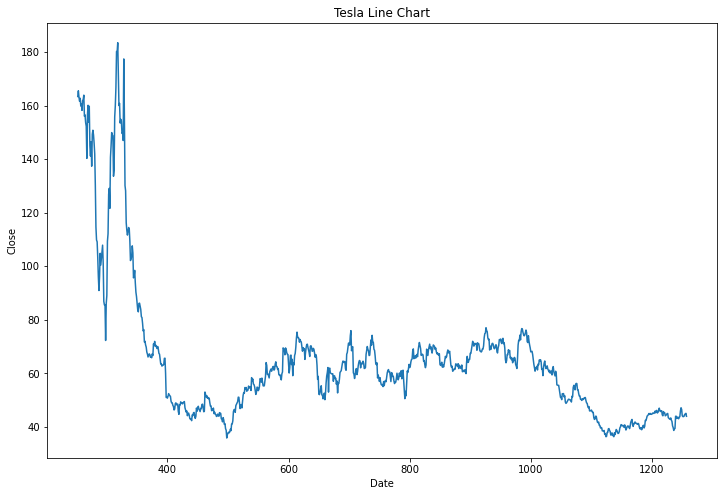

In [8]:
plt.figure(figsize=(12,8))
plt.plot(tsla_df_4['Close/Last'])
plt.title("Tesla Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### PLOT SECOND DF (LAST YEAR)

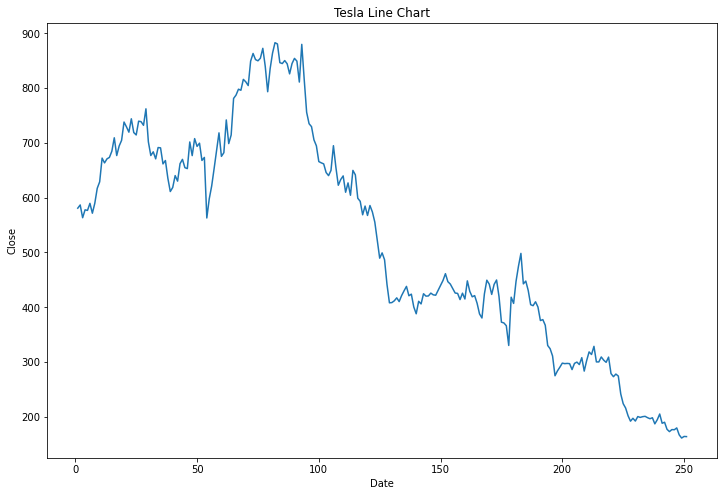

In [9]:
plt.figure(figsize=(12,8))
plt.plot(tsla_df_ls['Close/Last'])
plt.title("Tesla Line Chart")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### SHAPPING, FITTING, TRAINING, TESTING ML ON 1ST DF

In [10]:
tsla_df_4.shape

(1006, 12)

#### DEFINING THE X & Y

In [11]:
X = np.array(tsla_df_4['Open']).reshape(1006,-1)
Y = np.array(tsla_df_4['Close/Last']).reshape(1006,-1)

In [12]:
lr = LinearRegression()

In [13]:
lr.fit(X, Y)

LinearRegression()

#### PRINTING OUR LR AND COEF COUNT

In [14]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [0.32366725]
coefficient count: 1


#### SCORING 

In [15]:
from sklearn.metrics import accuracy_score
print('Accuracy:', lr.score(X, Y))

Accuracy: 0.9927719900839321


#### PRICE PREDICTION

In [16]:
# Predicting the price
lr.predict(X)

array([[164.01615779],
       [162.78693206],
       [163.68286918],
       ...,
       [ 45.11853238],
       [ 44.22458623],
       [ 43.70892465]])

#### DAILY RETURN

In [17]:
#daily Return
DA_RE = tsla_df_4['Close/Last'].pct_change(1)
DA_RE.head()

252         NaN
253    0.013123
254   -0.014548
255   -0.009257
256    0.006955
Name: Close/Last, dtype: float64

### PLOT LR PREDICTION OF 1ST DF

Text(0.5, 1.0, '4 Years CLosing Price vs Predicted Closing Price')

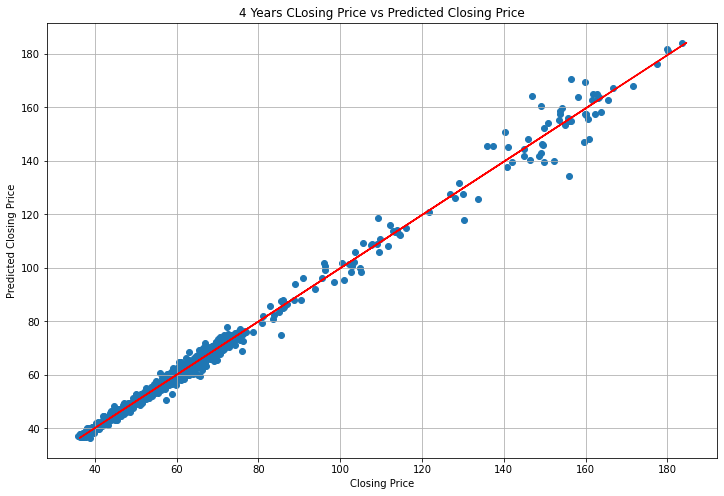

In [18]:
plt.figure(figsize=(12,8))
plt.scatter(tsla_df_4['Close/Last'], lr.predict(X))
plt.plot(X, lr.predict(X), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/tsla_4y.jpg', dpi=40)
plt.grid()
plt.title('4 Years CLosing Price vs Predicted Closing Price')

### TRAINING, TESTING ML ON 2ND DF

In [19]:
tsla_df_ls.shape

(251, 12)

#### DEFINING THE X & Y

In [20]:
X_ls = np.array(tsla_df_ls['Open']).reshape(251,-1)
Y_ls = np.array(tsla_df_ls['Close/Last']).reshape(251,-1)

In [21]:
lr.fit(X_ls, Y_ls)

LinearRegression()

#### PRINTING OUR LR AND COEF COUNT

In [22]:
print('Linear Regression intercept:', lr.intercept_)
print('coefficient count:', len(lr.coef_))

Linear Regression intercept: [3.38102435]
coefficient count: 1


#### SCORING

In [23]:
print('Accuracy:', lr.score(X_ls, Y_ls))

Accuracy: 0.991127567383132


#### PRICE PREDICTION

In [24]:
# Predicting the price
lr.predict(X_ls)

array([[595.74883469],
       [574.77135658],
       [552.46229056],
       [567.81530036],
       [575.32088502],
       [583.12856126],
       [601.14971548],
       [602.08878307],
       [598.85918554],
       [664.10699287],
       [665.00134295],
       [679.86742881],
       [680.16554551],
       [678.0588542 ],
       [702.762791  ],
       [666.7801059 ],
       [698.49972226],
       [695.41918307],
       [716.833899  ],
       [739.72926119],
       [718.66234807],
       [740.22612234],
       [703.72670164],
       [716.29728895],
       [718.4636036 ],
       [727.45679057],
       [741.81607805],
       [769.242814  ],
       [711.60691962],
       [684.77641706],
       [676.89619909],
       [676.50864738],
       [686.06825607],
       [689.34753972],
       [706.64824526],
       [687.42965565],
       [645.94174891],
       [601.35342855],
       [615.15623154],
       [641.22156791],
       [612.53280462],
       [667.09809704],
       [674.90875445],
       [683

### PLOT LR PREDICTION OF 2ND DF

Text(0.5, 1.0, '1 Year CLosing Price vs Predicted Closing Price')

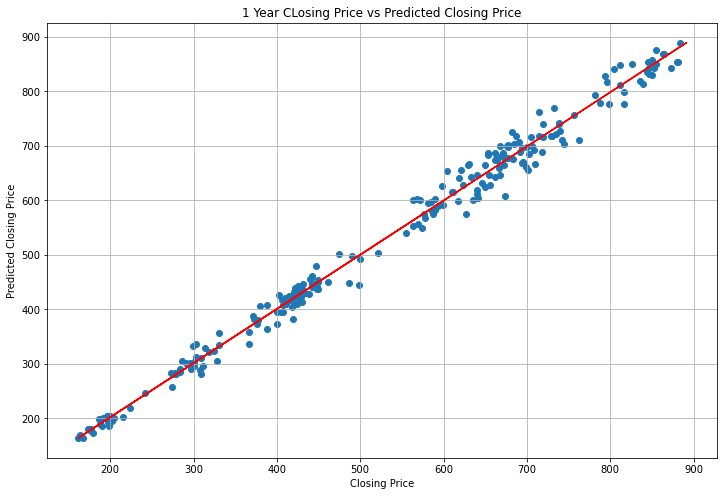

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(tsla_df_ls['Close/Last'], lr.predict(X_ls))
plt.plot(X_ls, lr.predict(X_ls), color = 'red')
plt.xlabel('Closing Price')
plt.ylabel('Predicted Closing Price')
plt.savefig('images/tsla_ls.jpg', dpi=40)
plt.grid()
plt.title('1 Year CLosing Price vs Predicted Closing Price')

### MODEL COMPARISON

<tr>
    <td> <img src="images/amzn_4y.jpg"style="width: 550px;"/> </td>
    <td> <img src="images/amzn_ls.jpg"style="width: 550px;"/> </td>
</tr>


#### SHAPING OUR DF FOR TF SEQUENTIAL MODEL

In [26]:
tsla_df.shape

(1257, 12)

#### BUILDING OUR MODEL

In [27]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')

#### IDENTIFY X & Y

In [28]:
Xc = np.array(tsla_df['Returns'], dtype = float) # Feature
Yc = np.array(tsla_df['Close/Last'], dtype = float) # Target

#### RUN & FIT MODEL

In [29]:
model.fit(Xc, Yc, epochs=100)

Epoch 1/100
40/40 [==============================] - 0s 846us/step - loss: 54282.2969
Epoch 2/100
40/40 [==============================] - 0s 872us/step - loss: 44413.5938
Epoch 3/100
40/40 [==============================] - 0s 975us/step - loss: 42418.2891
Epoch 4/100
40/40 [==============================] - 0s 872us/step - loss: 41989.5703
Epoch 5/100
40/40 [==============================] - 0s 744us/step - loss: 41909.9531
Epoch 6/100
40/40 [==============================] - 0s 769us/step - loss: 41902.5703
Epoch 7/100
40/40 [==============================] - 0s 1ms/step - loss: 41899.1602
Epoch 8/100
40/40 [==============================] - 0s 1ms/step - loss: 41883.7227
Epoch 9/100
40/40 [==============================] - 0s 1ms/step - loss: 41890.3516
Epoch 10/100
40/40 [==============================] - 0s 846us/step - loss: 41894.2344
Epoch 11/100
40/40 [==============================] - 0s 769us/step - loss: 41885.5039
Epoch 12/100
40/40 [==============================] - 0s 7

40/40 [==============================] - 0s 2ms/step - loss: 41875.8438
Epoch 96/100
40/40 [==============================] - 0s 1ms/step - loss: 41881.0586
Epoch 97/100
40/40 [==============================] - 0s 2ms/step - loss: 41875.4922
Epoch 98/100
40/40 [==============================] - 0s 1ms/step - loss: 41893.0117
Epoch 99/100
40/40 [==============================] - 0s 2ms/step - loss: 41880.2578
Epoch 100/100
40/40 [==============================] - 0s 1ms/step - loss: 41878.4297


#### TRANSFORM SCALE AND FIT MODEL

In [30]:
scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(np.array(tsla_df['Returns']).reshape(1257,-1))
X = np.array(normalized_X, dtype = float)
normalized_Y = scaler.fit_transform(np.array(tsla_df['Close/Last']).reshape(1257,-1))
Y = np.array(normalized_Y, dtype = float)

In [31]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

#### PRINT OUR PREDICTION

In [32]:
print((model.predict([0])))

[[155.75699]]
